In [1]:
import os
import tensorflow as tf
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Activation
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_log_error, mean_squared_error
import matplotlib.pyplot as plt
import math
import warnings
import pyautogui
import matplotlib.pyplot as plt
from IPython.display import clear_output
from numpy.random import seed
seed(15)
warnings.filterwarnings('ignore')

Using TensorFlow backend.


# Settings

In [2]:
# load = pyautogui.confirm(text='Refresh or Existing Data:', buttons=['Refresh', 'Existing'])
# tolog = pyautogui.confirm(text='Log Target Data?', buttons=['Yes', 'No'])
load = 'Refresh'
tolog = 'No'
print(load, tolog)

Refresh No


# Read in Data

In [3]:
inputs = pd.read_csv('data/traincleaned.csv')
testinputs = pd.read_csv('data/testcleaned.csv')

inputs = inputs.drop(columns=['SalePrice'])
alldata = pd.concat([inputs, testinputs])
alldata.set_index('Id', inplace=True)
alldata = alldata.fillna(0)
alldata = pd.get_dummies(alldata)
alldata = alldata.drop(columns=['Unnamed: 0'])
print(alldata.shape)

inputs_pre = alldata.loc[0:1460,]
testinputs_pre = alldata.loc[1461:]

numericalcolumns = []
for column in inputs_pre.columns:
    if set(inputs_pre[column].tolist()) != {0, 1}:
        numericalcolumns.append(column)

(2917, 345)


In [4]:
import numpy
from sklearn.preprocessing import MinMaxScaler, StandardScaler

prices = pd.read_csv('data/traincleaned.csv')
prices = prices['SalePrice']
prices = np.array(prices)
if tolog == 'Yes':
    prices = np.log10(prices)
prices

array([208500, 181500, 223500, ..., 266500, 142125, 147500], dtype=int64)

In [5]:
print(inputs_pre.shape, prices.shape)

(1458, 345) (1458,)


# Pre Process Data

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pickle

if load == 'Refresh':
    X_train_pre, X_test_pre, y_train, y_test = train_test_split(inputs_pre, prices, random_state=10, shuffle=True, test_size=.2)
    
    for column in numericalcolumns:
        try:
            X_scaler = StandardScaler().fit(X_train_pre[column].values.reshape(-1,1))            
            X_train_pre[column] = X_scaler.fit_transform(X_train_pre[column].values.reshape(-1,1))
            X_test_pre[column] = X_scaler.fit_transform(X_test_pre[column].values.reshape(-1,1))
            testinputs_pre[column] = X_scaler.fit_transform(testinputs_pre[column].values.reshape(-1,1))
            inputs_pre[column] = X_scaler.fit_transform(inputs_pre[column].values.reshape(-1,1))
        except Exception as e:
            print(column, e)
            
    objects = [X_train_pre, X_test_pre, testinputs_pre, inputs_pre, y_train, y_test]

    with open("objects.txt", "wb") as fp:
        pickle.dump(objects, fp)
        
else:
    with open("objects.txt", "rb") as fp:
        objects = pickle.load(fp)

    X_train_pre, X_test_pre, testinputs_pre, inputs_pre, y_train, y_test = objects   

# Function to drop columns from data

In [7]:
def dropcolumns(columnstodrop):
    dropcolumns = columnstodrop
    featureimportance = pd.read_csv('data/feature importance.csv')
    featureimportance = featureimportance.rename(columns={'0': 'importance', '1':'feature'})
    featureimportance = featureimportance.drop(columns=['Unnamed: 0'])
    featureimportance = featureimportance.sort_values(by='importance')
    featureimportance = featureimportance[0:dropcolumns]
    featureimportance = featureimportance['feature'].tolist()
    try:
        X_train = X_train_pre.drop(columns=featureimportance)
        X_test = X_test_pre.drop(columns=featureimportance)
        testinputs = testinputs_pre.drop(columns=featureimportance)
        inputs = inputs_pre.drop(columns=featureimportance)
    except:
        print(f'Couldnt drop columns')

    X_train = X_train.values
    X_test = X_test.values
    testinputs = testinputs.values
    inputs = inputs.values
    return X_train, X_test, testinputs, inputs

X_train, X_test, testinputs, inputs = dropcolumns(0)

Dropped 0 columns


In [8]:
print(inputs.shape, prices.shape)

(1458, 345) (1458,)


In [9]:
inputs

array([[-0.81430891, -0.80641361,  1.1676262 , ...,  1.        ,
         0.        ,  1.        ],
       [ 0.2773475 ,  0.42832816, -0.79435378, ...,  1.        ,
         0.        ,  1.        ],
       [-0.64222514, -0.57706553,  1.195195  , ...,  1.        ,
         0.        ,  1.        ],
       ...,
       [ 0.07837564,  0.2361218 ,  1.85225153, ...,  1.        ,
         0.        ,  1.        ],
       [-0.21739333, -0.07293924, -0.79435378, ...,  1.        ,
         0.        ,  1.        ],
       [ 0.26121465,  0.4131693 , -0.79435378, ...,  1.        ,
         0.        ,  1.        ]])

In [10]:
prices

array([208500, 181500, 223500, ..., 266500, 142125, 147500], dtype=int64)

# Find optimal hyperparameters (including columns to drop)

In [11]:
lastRMSLE = 1
lastDiff = 1

for columns in range(185, 215, 5):
    X_train, X_test, testinputs, inputs = dropcolumns(columns)
    for C in range(200, 225, 5):

        for degree in range(5, 7):

            for epsilon in [0.1, 1, 25, 100, 250, 1000]:


                for coef0 in range(2,3):
                    clf = SVR(kernel='poly', C=C, gamma='auto', degree=degree, epsilon=epsilon, coef0=coef0)
                    clf.fit(X_train, y_train) 
                    testpredictions = clf.predict(X_test)
                    trainpredictions = clf.predict(X_train)


                    testpredictions[testpredictions < y_train.min()/2] = y_train.min()
                    trainpredictions[trainpredictions < y_train.min()/2] = y_train.min()

                    if tolog == 'Yes':
                        testpredictions = np.power(10, testpredictions)
                        trainpredictions = np.power(10, trainpredictions)
                        y_test = np.power(10, y_test)
                        y_train = np.power(10, y_train)


                    testRMSLE = math.sqrt(mean_squared_log_error(y_test, testpredictions))
                    trainRMSLE = math.sqrt(mean_squared_log_error(y_train, trainpredictions))

                    if tolog == 'Yes':
                        testpredictions = np.log10(testpredictions)
                        trainpredictions = np.log10(trainpredictions)
                        y_test = np.log10(y_test)
                        y_train = np.log10(y_train)


                    diff = round(abs(testRMSLE - trainRMSLE), 3)
                    lastDiff = .03
                    if testRMSLE < lastRMSLE and diff < lastDiff:
                        lastDiff = diff
                        lastRMSLE = testRMSLE                    
                        print(f'C={C}, degree={degree}, epsilon={epsilon}, coef0={coef0}, testRMSLE={round(testRMSLE, 5)}, dropcolumns={columns}')
                        Cbest = C
                        columnsbest = columns
                        degreebest = degree
                        epsilonbest = epsilon
                        coef0best = coef0

print('---Done---')
#C=130,degree=7,epsilon=0.1,coef0=3 0.1359030945302552 first submission
#C=190,degree=9,epsilon=0.9,coef0=2 0.1359030945302552 second?
#C=100,degree=7,epsilon=0.1,coef0=2 0.1359030945302552
#C=200, degree=7, epsilon=4, coef0=2, standard scaler, no normalizing output data, 0.1248 Kaggle Score
#C=131, degree=6, epsilon=0.1, coef0=2, trainRMSLE = 0.1, testRMSLE=0.11711, diff=0.018, dropcolumns=20, kaggle score 0.12321
#C=210, degree=5, epsilon=13, coef0=3, trainRMSLE = 0.1, testRMSLE=0.13396, diff=0.034, no feat eng, no target scaling, dropcolumns = 4,
#C=200, degree=6, epsilon=100, coef0=2, trainRMSLE = 0.09, testRMSLE=0.11705, diff=0.022, dropcolumns=4, kaggle = 0.12285

Dropped 185 columns
C=200, degree=5, epsilon=0.1, coef0=2, testRMSLE=0.12128, dropcolumns=185
C=200, degree=5, epsilon=1, coef0=2, testRMSLE=0.12128, dropcolumns=185
C=200, degree=5, epsilon=25, coef0=2, testRMSLE=0.12126, dropcolumns=185
C=200, degree=5, epsilon=100, coef0=2, testRMSLE=0.12121, dropcolumns=185
C=200, degree=5, epsilon=250, coef0=2, testRMSLE=0.1211, dropcolumns=185
C=200, degree=5, epsilon=1000, coef0=2, testRMSLE=0.12024, dropcolumns=185
C=205, degree=5, epsilon=1000, coef0=2, testRMSLE=0.12016, dropcolumns=185
C=210, degree=5, epsilon=1000, coef0=2, testRMSLE=0.1201, dropcolumns=185
C=215, degree=5, epsilon=1000, coef0=2, testRMSLE=0.12003, dropcolumns=185
C=220, degree=5, epsilon=1000, coef0=2, testRMSLE=0.11996, dropcolumns=185
Dropped 190 columns
C=200, degree=5, epsilon=0.1, coef0=2, testRMSLE=0.11976, dropcolumns=190
C=200, degree=5, epsilon=1000, coef0=2, testRMSLE=0.11955, dropcolumns=190
C=205, degree=5, epsilon=1000, coef0=2, testRMSLE=0.11947, dropcolumns=

# Plot residuals

(292,) (292,)


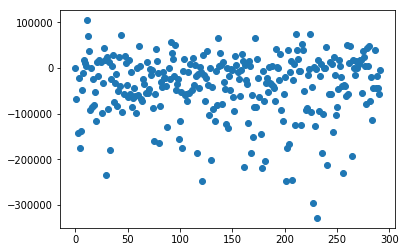

In [12]:
predicted = clf.predict(X_test)

if tolog == 'Yes':
    y_train = np.power(10, y_train)

# predicted[predicted < y_train.min()/2] = y_train.min()
predicted_graph = predicted
y_test_graph = predicted
print(predicted_graph.shape, y_test_graph.shape)
residuals = predicted_graph[0] - y_test_graph
xaxis = np.arange(len(residuals))
plt.scatter(xaxis, residuals)

(1166,) (1166,)


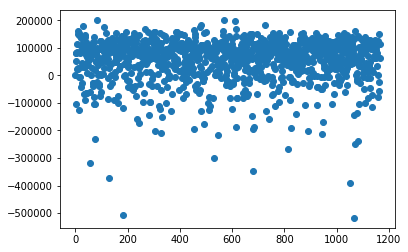

In [13]:
predicted = clf.predict(X_train)
if tolog == 'Yes':
    y_train = np.power(10, y_train)
# predicted[predicted < y_train.min()/2] = y_train.min()
predicted_graph = predicted
y_train_graph = predicted
print(predicted_graph.shape, y_train_graph.shape)
residuals = predicted_graph[0] - y_train_graph
xaxis = np.arange(len(residuals))
plt.scatter(xaxis, residuals)

# Train final model

In [14]:
try:
    skipthissection
    X_train, X_test, testinputs, inputs = dropcolumns(columnsbest)
    clf = SVR(kernel='poly', gamma='auto', C=131, degree=6, epsilon=0.1, coef0=2)      
    print('Used entered hyperparameters')
    print(clf)
except Exception as e:
    print(e)
    X_train, X_test, testinputs, inputs = dropcolumns(columnsbest)
    clf = SVR(kernel='poly', gamma='auto', C=Cbest, degree=degreebest, epsilon=epsilonbest, coef0=coef0best)
    print(f'C={Cbest}, degree={degreebest}, epsilon={epsilonbest}, coef0={coef0best}, dropcolumns={columnsbest}')

clf.fit(inputs, prices) 
predictions = clf.predict(testinputs)

if tolog == 'Yes':
    predictions = np.power(10, predictions)

predictions[predictions < y_train.min()/2] = y_train.min()

print(predictions)

name 'skipthissection' is not defined
Dropped 200 columns
C=220, degree=5, epsilon=0.1, coef0=2, dropcolumns=200
[122278.51315003 161775.72713906 190066.05648251 ... 181676.25108969
 122937.5730352  231928.01011072]


# Save predictions

In [15]:
submittest = pd.read_csv('data/testcleaned.csv')
submittest = submittest[['Id']]
submittest['SalePrice'] = predictions
submittest.to_csv(f'Submissions/SupportVector/SupportVector-C{Cbest}-degree{degreebest}-epsilon{epsilonbest}-coef0{coef0best}-dropcolumns{columnsbest}-testRMSLE{round(lastRMSLE, 5)}.csv', index=False)
submittest.head()

,Id,SalePrice
0,1461,122278.513150
1,1462,161775.727139
2,1463,190066.056483
3,1464,199039.694947
4,1465,184175.935449
